In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%pylab inline
%qtconsole
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


# Load Data table

In [2]:
# load data table
Predtbl = pd.read_csv('DataSample.csv','\t')
#Predtbl['sbj']     = Predtbl['sbj'].astype('category')
#Predtbl['trial']   = Predtbl['trial'].astype('category')
Predtbl['leftpic']   = Predtbl['leftpic'].astype('category')
Predtbl['rightpic']   = Predtbl['rightpic'].astype('category')

print ('Total number of subjects: ' + str(Predtbl.sbj.unique().size))
print ('Number of trial for each subject: ' + str(Predtbl.trial.unique().size))
print ('Unique conditions on the left: ' + str(Predtbl.leftpic.unique()))
print ('Unique conditions on the right: ' + str(Predtbl.rightpic.unique()))
isbj    = 2
sbjtbl  = Predtbl[Predtbl.sbj == isbj]

Total number of subjects: 55
Number of trial for each subject: 90
Unique conditions on the left: [A, C, B]
Categories (3, object): [A, C, B]
Unique conditions on the right: [C, A, B]
Categories (3, object): [C, A, B]


# Preprocess

In [3]:
# registrate fixation by their spatial location
nitem,_ = sbjtbl.shape
xfix    = np.asarray(sbjtbl['xfix'])
yfix    = np.asarray(sbjtbl['yfix'])

# leftrect1,leftrect2,leftrect3,leftrect4,rightrect1,rightrect2,rightrect3,rightrect4 \
# = np.asarray(sbjtbl.iloc[0,13:21])
loc     = np.zeros(nitem)
index1  = [(sbjtbl['leftrect1'] < xfix) & (sbjtbl['leftrect3'] > xfix) &\
          (sbjtbl['leftrect2'] < yfix) & (sbjtbl['leftrect4'] > yfix)]
loc[np.where(index1)[1]] = 1 # left stimulus
index2  = [(sbjtbl['rightrect1'] < xfix) & (sbjtbl['rightrect3'] > xfix) &\
          (sbjtbl['rightrect2'] < yfix) & (sbjtbl['rightrect4'] > yfix)]
loc[np.where(index2)[1]] = -1 # right stimulus

trialall = np.asarray([sbjtbl.sbj-1])*[sbjtbl.trial.max()] + np.asarray(sbjtbl.trial)
trial    = np.unique(trialall)
ntrial   = np.size(trial)

# Temporal plot

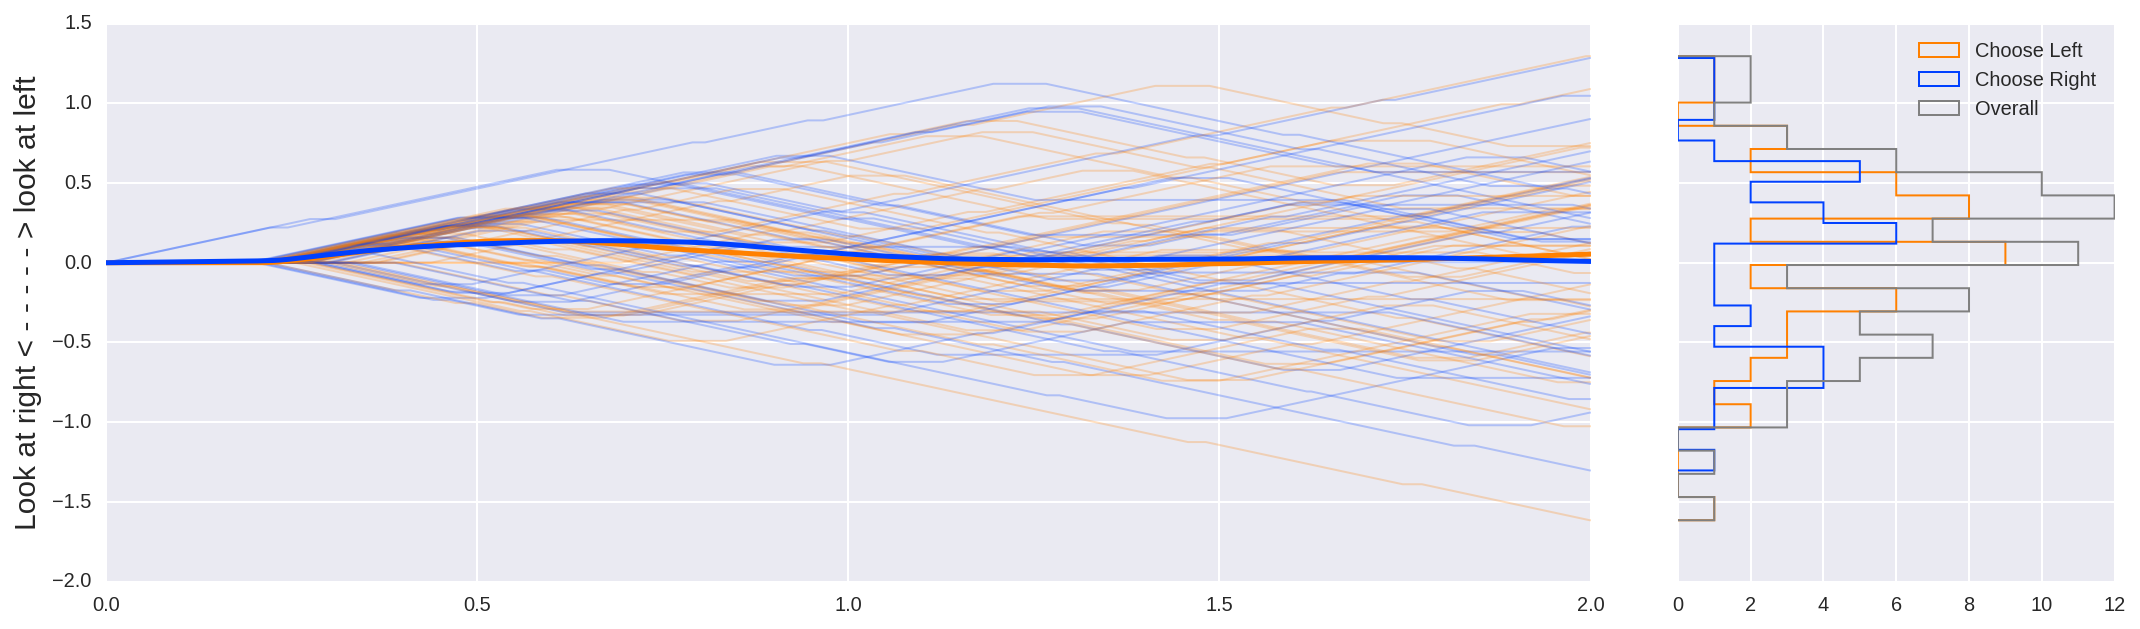

In [14]:
nsamp    = 2000
timemax  = 2.0
timeline = np.linspace(0,timemax,nsamp)
nbins    = 20
plt.figure(figsize = (18,5))
gs  = gridspec.GridSpec(1, 4)

colorspec = [[1,0.5,0],[0,0.25,1]]
ax1 = plt.subplot(gs[0,0:3])
dataall = []
respall = []
leftdur = np.zeros(ntrial)
rightdur= np.zeros(ntrial)
sp_all  = np.zeros((ntrial,nsamp))

respond = np.asarray(sbjtbl['respond'])
for tr,itrial in enumerate(trial):
    index = np.where(trialall==itrial)[1]
    resp  = respond[index[0]] - 1
    scanpath = np.zeros(nsamp)
    trfixdur = sbjtbl['fixdur'].iloc[index]
    leftdur[tr]  = np.nansum(trfixdur[loc[index]== 1])
    rightdur[tr] = np.nansum(trfixdur[loc[index]==-1])
    for ij in index:
        onset   = sbjtbl['time_start'].iloc[ij]
        offset  = sbjtbl['time_end'].iloc[ij]
        sampon  = np.where(onset > timeline)[0][-1]
        if offset >= timemax:
            sampoff = nsamp
        else:
            sampoff = np.where(offset < timeline)[0][0]
        scanadd = np.linspace(0,sbjtbl['fixdur'].iloc[ij],sampoff-sampon)
        scanpath[sampon:sampoff] = scanpath[sampon:sampoff] + loc[ij]*scanadd
        scanpath[sampoff:]       = scanpath[sampoff:] + loc[ij]*scanadd[-1]
    ax1.plot(timeline,scanpath,lw = 1,color=colorspec[resp],alpha = .25)
    sp_all[tr,:] = scanpath
    dataall.append([scanpath[-1]])
    respall.append([resp])
    
ax1.set_ylabel('Look at right < - - - - - > look at left',fontsize = 15)

dataall = np.asarray(dataall)
respall = np.asarray(respall)

ax2 = plt.subplot(gs[0,3],sharey=ax1)
for i in range(2):
    pltline = np.mean(sp_all[np.where(respall==i)[0],:],axis=0)
    ax1.plot(timeline,pltline,lw = 2.5,color=colorspec[i])
    ax2.hist(dataall[respall==i],bins=nbins,normed=False,\
             orientation='horizontal',histtype='step',lw = 1,color=colorspec[i])
ax2.hist(dataall, bins=nbins,normed=False,orientation='horizontal',histtype='step',lw = 1,color='grey')
ax2.legend(['Choose Left','Choose Right','Overall'])

plt.setp(ax2.get_yticklabels(), visible=False)

plt.show()

/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


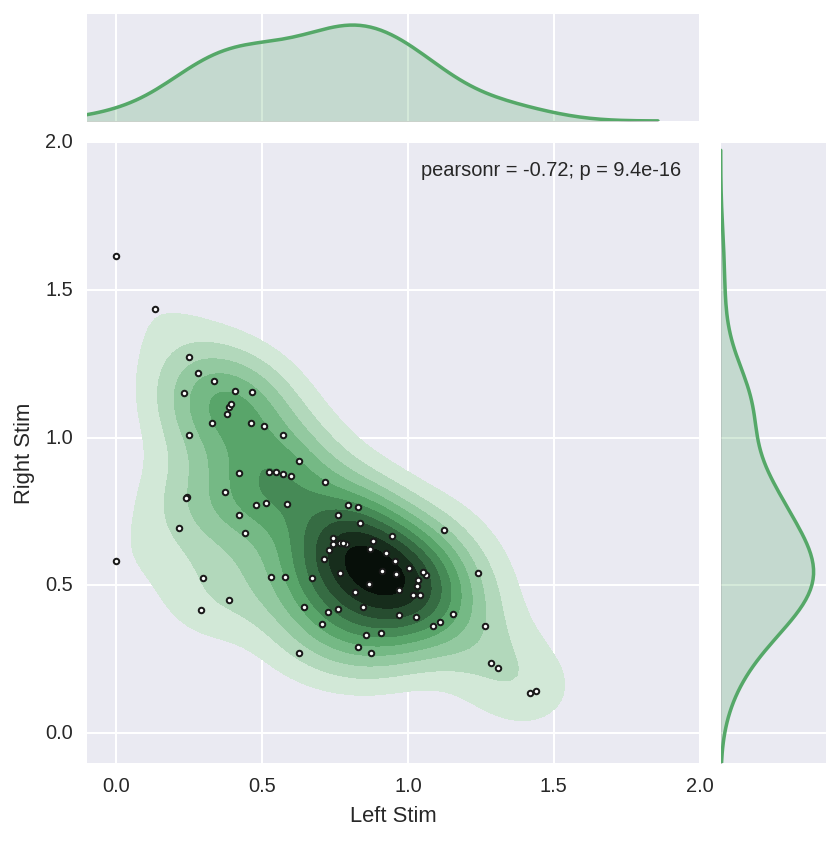

In [15]:
label1 = "Left Stim"
label2 = "Right Stim"

# Descriptive result
sns.set(color_codes=True)
datmp = np.zeros((ntrial, 2))
datmp[:,0]=leftdur
datmp[:,1]=rightdur

df = pd.DataFrame(datmp,columns=["x", "y"])

# sns.jointplot(x="x", y="y", data=df);

g = sns.jointplot(x="x", y="y", data=df, kind="kde", color="g", xlim=(-.1,timemax), ylim=(-.1,timemax))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels(label1, label2);
plt.show()

In [20]:
unicondi    = Predtbl.leftpic.unique()
c0,c1       = 0,2
print('Visualizing Condition ' + str(unicondi[c0]) + ' and ' + str(unicondi[c1]))
selectcondi = (Predtbl.leftpic == unicondi[c0]) & (Predtbl.rightpic == unicondi[c1]) | \
             (Predtbl.rightpic == unicondi[c0]) & (Predtbl.leftpic == unicondi[c1]) 

sbjtbl  = Predtbl[selectcondi].copy()
# registrate fixation by their spatial location
nitem,_ = sbjtbl.shape
xfix    = np.asarray(sbjtbl['xfix'])
yfix    = np.asarray(sbjtbl['yfix'])

# leftrect1,leftrect2,leftrect3,leftrect4,rightrect1,rightrect2,rightrect3,rightrect4 \
# = np.asarray(sbjtbl.iloc[0,13:21])
loc     = np.zeros(nitem)
index1  = [(sbjtbl['leftrect1'] < xfix) & (sbjtbl['leftrect3'] > xfix) &\
          (sbjtbl['leftrect2'] < yfix) & (sbjtbl['leftrect4'] > yfix)]
loc[np.where(index1)[1]] =  1 # left stimulus
index2  = [(sbjtbl['rightrect1'] < xfix) & (sbjtbl['rightrect3'] > xfix) &\
          (sbjtbl['rightrect2'] < yfix) & (sbjtbl['rightrect4'] > yfix)]
loc[np.where(index2)[1]] = -1 # right stimulus

trialall = np.asarray([sbjtbl.sbj-1])*[sbjtbl.trial.max()] + np.asarray(sbjtbl.trial)
trial    = np.unique(trialall)
ntrial   = np.size(trial)

respond  = np.asarray(sbjtbl['respond'])
# flip response and fixloc
findopps = np.where(sbjtbl.leftpic == unicondi[c1])[0]
loc[findopps]     = -loc[findopps]
respond[findopps] = 3 - respond[findopps]

Visualizing Condition A and B


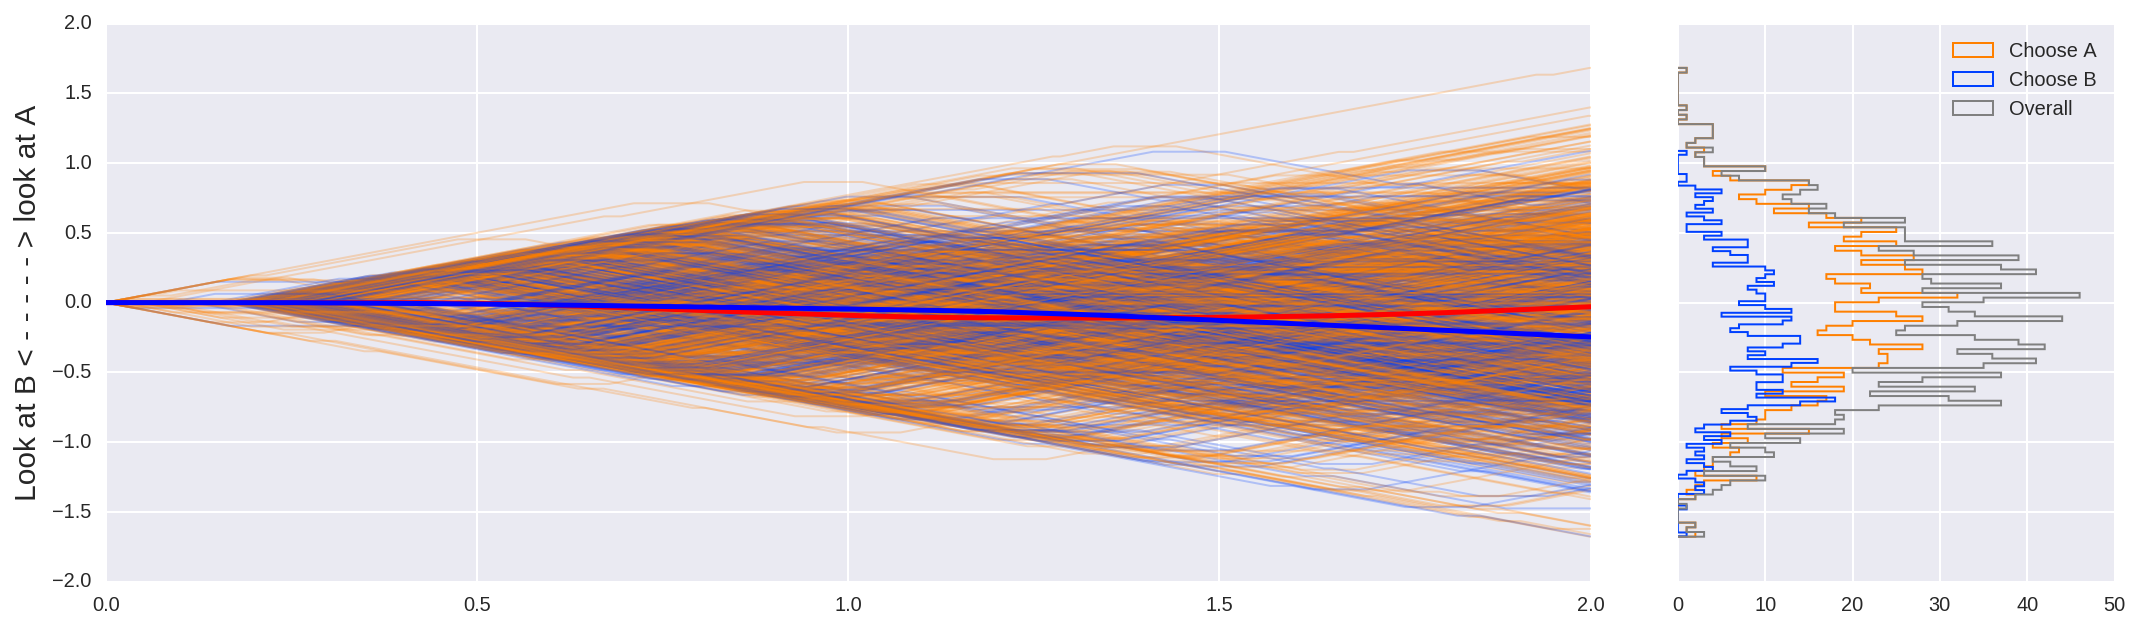

/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


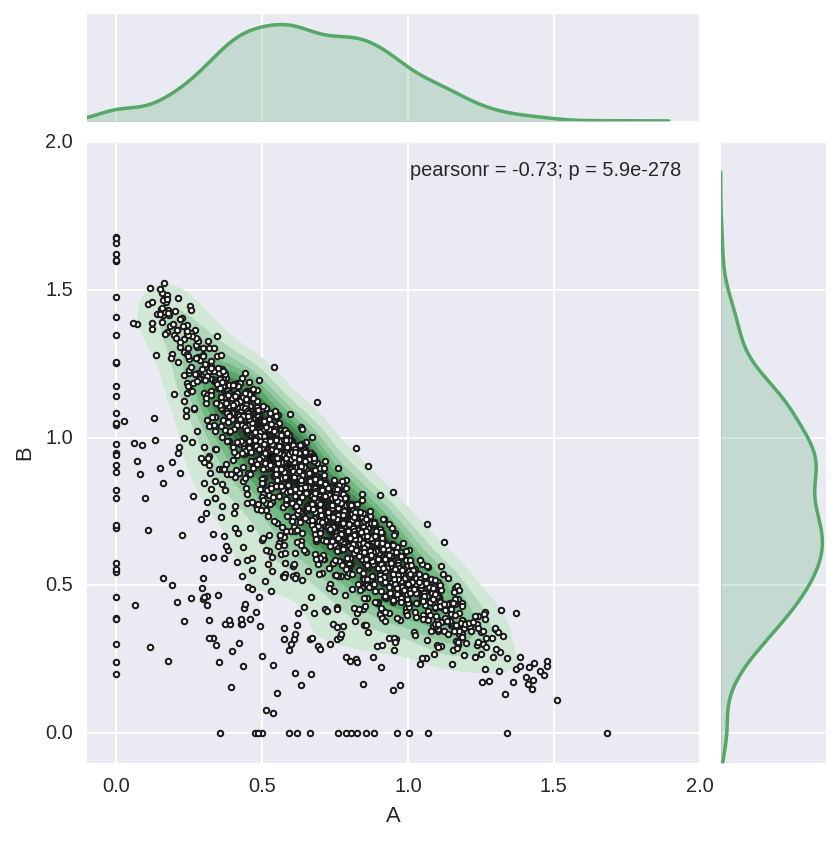

In [42]:
nsamp    = 2000
timemax  = 2.0
timeline = np.linspace(0,timemax,nsamp)
nbins    = 100
plt.figure(figsize = (18,5))
gs  = gridspec.GridSpec(1, 4)

colorspec = [[1,0.5,0],[0,0.25,1]]
colorspec2= [[1,0,0],[0,0,1]]
ax1 = plt.subplot(gs[0,0:3])
dataall = []
respall = []
leftdur = np.zeros(ntrial)
rightdur= np.zeros(ntrial)
sp_all  = np.zeros((ntrial,nsamp))

for tr,itrial in enumerate(trial):
    index = np.where(trialall==itrial)[1]
    resp  = respond[index[0]] - 1
    scanpath = np.zeros(nsamp)
    trfixdur = sbjtbl['fixdur'].iloc[index]
    leftdur[tr]  = np.nansum(trfixdur[loc[index]== 1])
    rightdur[tr] = np.nansum(trfixdur[loc[index]==-1])
    for ij in index:
        onset   = sbjtbl['time_start'].iloc[ij]
        offset  = sbjtbl['time_end'].iloc[ij]
        sampon  = np.where(onset > timeline)[0][-1]
        if offset >= timemax:
            sampoff = nsamp
        else:
            sampoff = np.where(offset < timeline)[0][0]
        scanadd = np.linspace(0,sbjtbl['fixdur'].iloc[ij],sampoff-sampon)
        scanpath[sampon:sampoff] = scanpath[sampon:sampoff] + loc[ij]*scanadd
        scanpath[sampoff:]       = scanpath[sampoff:] + loc[ij]*scanadd[-1]
    ax1.plot(timeline,scanpath,lw = 1,color=colorspec[resp],alpha = .25)
    sp_all[tr,:] = scanpath
    dataall.append([scanpath[-1]])
    respall.append([resp])
    
ax1.set_ylabel('Look at ' + str(unicondi[c1]) + ' < - - - - - > look at ' + str(unicondi[c0]),fontsize = 15)

dataall = np.asarray(dataall)
respall = np.asarray(respall)

from scipy.stats import gaussian_kde as gkde

ax2 = plt.subplot(gs[0,3],sharey=ax1)
for i in range(2):
    pltline = np.mean(sp_all[np.where(respall==i)[0],:],axis=0)
    ax1.plot(timeline,pltline,lw = 2.5,color=colorspec2[i])
    ax2.hist(dataall[respall==i],bins=nbins,normed=False,\
             orientation='horizontal',histtype='step',lw = 1,color=colorspec[i])
    #empdf  = gkde(dataall[respall==i])
    #xrange = np.linspace(np.min(dataall[respall==i]),np.max(dataall[respall==i]),200)
    #ax2.plot(empdf(xrange),xrange,color=colorspec[i])

ax2.hist(dataall, bins=nbins,normed=False,orientation='horizontal',histtype='step',lw = 1,color='grey')
#empdf  = gkde(dataall.flatten())
#xrange = np.linspace(np.min(dataall),np.max(dataall),200)
#ax2.plot(empdf(xrange),xrange,color='grey')

ax2.legend(['Choose ' + str(unicondi[c0]),'Choose ' + str(unicondi[c1]),'Overall'])

plt.setp(ax2.get_yticklabels(), visible=False)

plt.show()

label1 = str(unicondi[c0])
label2 = str(unicondi[c1])

# Descriptive result
sns.set(color_codes=True)
datmp = np.zeros((ntrial, 2))
datmp[:,0]=leftdur
datmp[:,1]=rightdur

df = pd.DataFrame(datmp,columns=["x", "y"])
g  = sns.jointplot(x="x", y="y", data=df, kind="kde", color="g", xlim=(-.1,timemax), ylim=(-.1,timemax))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels(label1, label2);
plt.show()